<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/06_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet


---


2019年に画像分類タスクでSoTAを達成したEfficientNetについて説明します．

## 概要
EfficientNetは，MnasNetにより得たネットワーク構造を拡張して精度を重視するネットワークに拡張しています．EfficientNetでは，畳み込みニューラルネットワークにおけるネットワークの深さや広さ，解像度等がモデルの性能にどう影響を及ぼすかに着眼しています．
ネットワークの深さ，広さ，解像度をバランスよくスケーリング可能な複合係数（Compound Coefficient）を導入しています．この時，各層のフィルタ数や層数，入力画像サイズの関係を定式化し，１つのパラメータでこれらの値を決定します．これにより，非常に簡単に新たな高精度なネットワーク構造を獲得できるようになりました．EfficientNetは，高精度度なだけでなく，様々なタスクのベースネットワークに活用され，転移学習に有用なネットワーク構造となっています．



<img src="https://drive.google.com/uc?export=view&id=1sUuvFaJ-iqEQOMqUIyTkS-Ycw7QP2TSd" width = 100%>

<img src="https://drive.google.com/uc?export=view&id=1jXTpHVUgc5swKxwBaC0RYwjDsfHuPVSg" width = 60%>



## 事前準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

### パッケージのインポート
必要なパッケージをインポートします．

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import matplotlib.pyplot as plt
from time import time
import os

GPUが利用できるか確認します．GPUが利用できる場合はdeviceに"cuda"を代入，利用できない場合はdeviceに"cpu"を代入します．



In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print('device:{}'.format(device))

device:cuda


In [9]:
!nvidia-smi

Sun Feb 14 20:01:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |    857MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## データセットの用意
今回の物体認識では，CIFAR-10データセットを使用します．CIFAR-10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットです．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

### ダウンロードとデータ拡張
データ拡張の設定を行います．ここでは，ランダムリサイズクロップとランダムクリップをします．また，画像の正規化(明るさの正規化)も行います．
データセットおよびデータ拡張をデータローダに与えます．ミニバッチサイズは６４とします．
CIFAR10のデータセットはPyTorch公式よりダウンロードして使うことができます．torchvision.datasets.CIFAR10を指定することでデータセットを自動でダウンロードします．
クラス名はディレクトリ名から作成して学習データの場合はtrain_data.classesに含まれています．

学習には，大量のデータを利用しますが，不十分な場合がほとんどです．学習データが少ない状態で学習を進めると，過学習や精度に影響します．そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします．一般的な方法は，画像の左右反転，明るさ変換などです．また，画像の一部にマスク処理をかけるRandom Erasingも行います．

In [10]:
batch_size = 64

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = torchvision.datasets.CIFAR10(root="./", train=True, transform=transform_train, download=True)
val_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=80,shuffle=True, num_workers=4)

class_names = train_data.classes
print(class_names)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### CIFAR-10データセットの表示
CIFAR-10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．
学習データは5万枚，テストデータは1万枚，画像サイズは3x32x32の形式となっています． これは32x32ピクセルのカラー画像という意味になります．

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


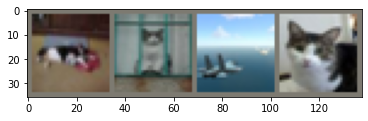

  cat   cat airplane   cat


In [11]:
# 画像の表示
def imshow(img):
    npimg = img.numpy()
    npimg = ((npimg.transpose((1,2,0))  * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465])  # unnormalize
    plt.imshow(npimg)
    plt.show()

# データの取得
dataiter = iter(val_loader)
images, labels = dataiter.next()

# 画像表示を実行
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

## ネットワークの定義
EfficientNetはB0からB7までネットワーク構造が違うモデルがあります．ネットワーク構造をここではB1を利用します．
EfficientNet-B0〜B7の幅，深さ，解像度は以下のように定義されています．
'efficientnet-b0': (1.0, 1.0, 224, 0.2),

'efficientnet-b1': (1.0, 1.1, 240, 0.2),

'efficientnet-b2': (1.1, 1.2, 260, 0.3),

'efficientnet-b3': (1.2, 1.4, 300, 0.3),

'efficientnet-b4': (1.4, 1.8, 380, 0.4),

'efficientnet-b5': (1.6, 2.2, 456, 0.4),

'efficientnet-b6': (1.8, 2.6, 528, 0.5),

'efficientnet-b7': (2.0, 3.1, 600, 0.5),

In [14]:
class Swish(nn.Module):    # Swish activation
    def forward(self, x):
        return x * torch.sigmoid(x)


class SEblock(nn.Module):  # Squeeze Excitation block                                  
    def __init__(self, ch_in, ch_sq):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch_in, ch_sq, 1),
            Swish(),
            nn.Conv2d(ch_sq, ch_in, 1),
        )
        self.se.apply(weights_init)

    def forward(self, x):
        return x * torch.sigmoid(self.se(x))

def weights_init(m):  # Initialize weights
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)


class ConvBN(nn.Module):  # (Convolution -> BatchNormaization)
    def __init__(self, ch_in, ch_out, kernel_size,
                 stride=1, padding=0, groups=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size,
                      stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(ch_out),
        )
        self.layers.apply(weights_init)

    def forward(self, x):
        return self.layers(x)


class DropConnect(nn.Module):  # DropConnect layer
    def __init__(self, drop_rate):
        super().__init__()
        self.drop_rate = drop_rate

    def forward(self, x):
        if self.training:
            keep_rate = 1.0 - self.drop_rate
            r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
            r += keep_rate
            mask = r.floor()
            return x.div(keep_rate) * mask
        else:
            return x


class BMConvBlock(nn.Module):  # pixel-wise -> depth-wise -> squeeze excitation -> drop connect
    def __init__(self, ch_in, ch_out,
                 expand_ratio, stride, kernel_size,
                 reduction_ratio=4, drop_connect_rate=0.2):
        super().__init__()
        self.use_residual = (ch_in==ch_out) & (stride==1)
        ch_med = int(ch_in * expand_ratio)
        ch_sq = max(1, ch_in//reduction_ratio)
                                                       
        if expand_ratio != 1.0:
            layers = [ConvBN(ch_in, ch_med, 1),Swish()]
        else:
            layers = []

        layers.extend([
            ConvBN(ch_med, ch_med, kernel_size, stride=stride,
                   padding=(kernel_size-1)//2, groups=ch_med), # depth-wise    
            Swish(),
            SEblock(ch_med, ch_sq), # Squeeze Excitation                        
            ConvBN(ch_med, ch_out, 1), # pixel-wise                             
        ])

        if self.use_residual:
            self.drop_connect = DropConnect(drop_connect_rate)

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.drop_connect(self.layers(x))
        else:
            return self.layers(x)


class EfficientNet(nn.Module):  # define Network
    def __init__(self, width_mult=1.0, depth_mult=1.0,
                 resolution=False, dropout_rate=0.2, 
                 input_ch=3, num_classes=10):
        super().__init__()

        # expand_ratio, channel, repeats, stride, kernel_size                   
        settings = [
            [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
            [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
            [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
            [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
            [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
            [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
            [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
        ]

        ch_out = int(math.ceil(32*width_mult))
        features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
        features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])

        ch_in = ch_out
        for t, c, n, s, k in settings:
            ch_out  = int(math.ceil(c*width_mult))
            repeats = int(math.ceil(n*depth_mult))
            for i in range(repeats):
                stride = s if i==0 else 1
                features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
                ch_in = ch_out

        ch_last = int(math.ceil(1280*width_mult))
        features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

        self.features = nn.Sequential(*features)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(ch_last, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def _efficientnet(w_mult, d_mult, resolution, drop_rate,
                  input_ch, num_classes=10):
    model = EfficientNet(w_mult, d_mult,
                         resolution, drop_rate,
                         input_ch, num_classes)
    return model


def efficientnet_b0(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.0, 224, 0.2)              
    return _efficientnet(1.0, 1.0, None, 0.2, input_ch, num_classes)

def efficientnet_b1(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (1.0, 1.1, 240, 0.2)              
    return _efficientnet(1.0, 1.1, None, 0.2, input_ch, num_classes)

def efficientnet_b2(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (1.1, 1.2, 260, 0.3)              
    return _efficientnet(1.1, 1.2, None, 0.3, input_ch, num_classes)

def efficientnet_b3(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (1.2, 1.4, 300, 0.3)              
    return _efficientnet(1.2, 1.4, None, 0.3, input_ch, num_classes)

def efficientnet_b4(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (1.4, 1.8, 380, 0.4)              
    return _efficientnet(1.4, 1.8, None, 0.4, input_ch, num_classes)

def efficientnet_b5(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (1.6, 2.2, 456, 0.4)              
    return _efficientnet(1.6, 2.2, None, 0.4, input_ch, num_classes)

def efficientnet_b6(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (1.8, 2.6, 528, 0.5)              
    return _efficientnet(1.8, 2.6, None, 0.5, input_ch, num_classes)

def efficientnet_b7(input_ch=3, num_classes=10):
    #(w_mult, d_mult, resolution, droprate) = (2.0, 3.1, 600, 0.5)              
    return _efficientnet(2.0, 3.1, None, 0.5, input_ch, num_classes)

## 損失関数と最適化手法の定義
学習に使用する損失関数と最適化手法を定義します．
今回は，分類問題を扱うため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．
最適化手法には，確率的勾配降下法 (stochastic gradient descent: SGD) を用いて学習します．

In [15]:
model = efficientnet_b0()
print("======== netowrk architecutre ========\n")
print(model)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

======== netowrk architecutre ========

EfficientNet(
  (features): Sequential(
    (0): ConvBN(
      (layers): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Swish()
    (2): BMConvBlock(
      (layers): Sequential(
        (0): ConvBN(
          (layers): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): Swish()
        (2): SEblock(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): Swish()
            (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (3): ConvBN(
          (layers): Sequenti

ネットワークの構造とモデルサイズを確認します．

In [16]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             864
       BatchNorm2d-2           [-1, 32, 15, 15]              64
            ConvBN-3           [-1, 32, 15, 15]               0
             Swish-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 32, 15, 15]             288
       BatchNorm2d-6           [-1, 32, 15, 15]              64
            ConvBN-7           [-1, 32, 15, 15]               0
             Swish-8           [-1, 32, 15, 15]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             264
            Swish-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          SEblock-13           [-1, 32, 15, 15]               0
           Conv2d-14           [-1, 16,

## 学習
読み込んだCIFAR-10データセットと作成したネットワークを用いて，学習を行います．
今回は，学習エポック数を25とします．
各更新において，学習用データと教師データをそれぞれ`inputs`と`targets`とします．
学習モデルに`inputs`を与えて，ネットワークの出力を取得します．
出力と教師ラベル`targets`との誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．
認識精度も同時に計算して，`print`関数で学習経過における誤差や認識精度を表示します．
テストデータに対する認識精度も出力しながら，誤差と精度の変化を確認します．

In [17]:
# エポック数の設定
epoch_num = 25
n_iter = len(train_data) / batch_size

best_acc = 0.
start = time()
for epoch in range(1, epoch_num+1):
    model.train() 
    sum_loss = 0.0
    count = 0
    optimizer.step()
    # scheduler.step()

    for image, label in train_loader:
        image = image.cuda()
        label = label.cuda()
            
        y = model(image)
        #tensor(max, max_indices)なのでpredは0,1のラベル
        _, preds = torch.max(y, 1)
        loss = criterion(y, label)
                
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()* image.size(0)      
        count += torch.sum(preds == label.data)

    train_loss = sum_loss / len(train_data)
    train_acc = float(count) / len(train_data)
    print("epoch: {}, mean loss: {:.4f}, train accuracy: {:.4f}, elapsed_time :{:.4f}".format(epoch,
                                                                                 train_loss,
                                                                                 train_acc,
                                                                                 time() - start))

    # ネットワークを評価モードへ変更
    model.eval()

    # 評価の実行
    count = 0
    with torch.no_grad():
        for image, label in val_loader:
            image = image.cuda()
            label = label.cuda()
            
            y = model(image)

            #tensor(max, max_indices)なのでpredは0,1のラベル
            _, preds = torch.max(y, 1)
            count += torch.sum(preds == label.data)
     
    val_acc = count.item() / len(val_data)
    if best_acc < val_acc:
      best_acc = val_acc
    print("val accuracy: {:.4f}".format(val_acc))

print("best accuracy: {:.4f}".format(best_acc))


epoch: 1, mean loss: 2.3247, train accuracy: 0.1211, elapsed_time :58.5762
val accuracy: 0.1025
epoch: 2, mean loss: 2.2558, train accuracy: 0.1506, elapsed_time :120.1184
val accuracy: 0.1972
epoch: 3, mean loss: 2.1189, train accuracy: 0.2000, elapsed_time :179.9455
val accuracy: 0.2603
epoch: 4, mean loss: 2.0320, train accuracy: 0.2309, elapsed_time :239.1572
val accuracy: 0.2902
epoch: 5, mean loss: 1.9717, train accuracy: 0.2539, elapsed_time :297.8199
val accuracy: 0.3157
epoch: 6, mean loss: 1.9298, train accuracy: 0.2756, elapsed_time :356.1937
val accuracy: 0.3226
epoch: 7, mean loss: 1.8874, train accuracy: 0.2916, elapsed_time :413.2390
val accuracy: 0.3509
epoch: 8, mean loss: 1.8520, train accuracy: 0.3019, elapsed_time :470.2068
val accuracy: 0.3743
epoch: 9, mean loss: 1.8155, train accuracy: 0.3210, elapsed_time :526.7478
val accuracy: 0.3920
epoch: 10, mean loss: 1.7865, train accuracy: 0.3338, elapsed_time :582.8190
val accuracy: 0.4017
epoch: 11, mean loss: 1.7656, 

## 評価
テストデータに対する識別結果を確認します．

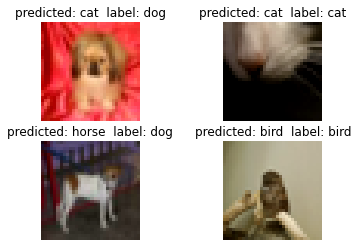

In [18]:
def tensor_to_numpy(inp):
  "imshow for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

model.eval()
num_images = 4
count = 0
fig = plt.figure()

with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.cuda()
        label = label.cuda()

        y = model(image)
        _, preds = torch.max(y, 1)

        for j in range(image.size()[0]):
            count += 1
            if count - 1 >= num_images:
                break
            ax = fig.add_subplot(num_images//2, 2, count)
            ax.axis('off')
            ax.set_title('predicted: {}  label: {}'
                         .format(class_names[preds[j]], class_names[label[j]]))
            ax.imshow(tensor_to_numpy(image.cpu().data[j]))


学習済みのネットワークを用いて，テストデータに対する認識精度の確認を行います．
`model.eval()`により，ネットワーク演算を評価モードへ変更します．
これを用いると，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です．また，`torch.no_grad()`を適用することで，学習時に必要な勾配情報を保持することなく演算を行います．

In [25]:
model.eval()
running_loss = 0.0
running_acc = 0.0
test_loss = 0
correct = 0
total = 0
count = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        running_loss += loss
        running_acc += 100.*correct/total
        count += 1

    print('Test Loss: %.5f | Test Acc: %.3f%%'
                  % (test_loss/count, running_acc/count))

Test Loss: 1.45104 | Test Acc: 46.762%


## 課題
1. 学習率やエポック数を変更して実験を行いましょう．(それぞれのネットワークモデルの性能の変化を調査する)

In [ ]:
#ここにコードを書く

2. EfficientNetのモデルサイズを変更して実験を行いましょう．(B1からB2等)

In [ ]:
#ここにコードを書く

## 参考文献
 - [1] Mingxing Tan and Quoc V. Le, "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks". In 2019 International Conference on Machine Learning, pp. 6105-6114, 2019.
